In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path

import lightning as pl
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

from ciflows.vae import Conv_VAE

In [34]:
# reload the model from checkpoint
root = Path('/Users/adam2392/Documents/ciflows/results/')

model_dir = root / 'vae'
epoch=200

model_fname = model_dir / f'vae_checkpoint_epoch_{epoch}.pt'
checkpoint = torch.load(model_fname, map_location='mps')

print(checkpoint.keys())

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train_loss'])


/var/folders/6_/sl83qtkd68x3_mvfys07_6qm0000gn/T/ipykernel_75908/3744233437.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_fname, map_loca

In [36]:
model = Conv_VAE(channels=1, height=28, width=28, hidden_size=16)
model.load_state_dict(state_dict=checkpoint['model_state_dict'])


<All keys matched successfully>

In [37]:
def sample_from_vae(model, n_samples=10, latent_dim=20):
    # Set the model to evaluation mode
    model.eval()
    
    # Sample from the standard normal distribution
    z = torch.randn(n_samples, latent_dim)  # Latent space samples
    
    with torch.no_grad():
        # Generate new samples using the decoder
        samples = model.decode(z).cpu()  # Decode the samples to image space
    
    return samples

In [39]:

samples = sample_from_vae(model, n_samples=16, latent_dim=16)

torch.Size([3, 122, 122])


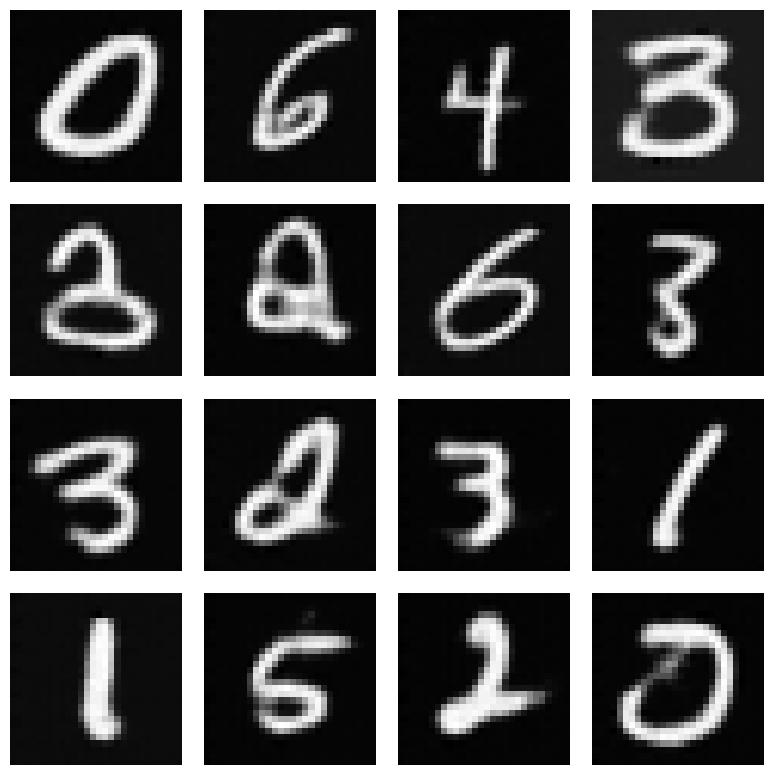

In [40]:
num_samples = 16

# Visualize generated samples
grid_size = make_grid(samples, nrow=4, padding=2)
save_image(grid_size, 'generated_samples.png', normalize=True)

print(grid_size.shape)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(num_samples):
    ax = axes[i // 4, i % 4]
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

In [35]:
num_samples = 2

z, log_q = model.model.q0(num_samples)
for flow in model.model.flows:
    z, log_det = flow(z)
    log_q -= log_det
    print()
    print(flow, z.flatten()[0], log_q[0])
return z, log_q


GlowBlock(
  (flows): ModuleList(
    (0): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): ConvNet2d(
            (net): Sequential(
              (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): LeakyReLU(negative_slope=0.0)
              (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              (3): LeakyReLU(negative_slope=0.0)
              (4): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
        )
        (2): Merge()
      )
    )
    (1): Invertible1x1Conv()
    (2): ActNorm()
  )
) tensor(1.1539, grad_fn=<SelectBackward0>) tensor(-152.7195, grad_fn=<SelectBackward0>)

GlowBlock(
  (flows): ModuleList(
    (0): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): ConvNet2d(
            (net): Sequential(
              (0): Conv2d(1, 64, kernel

SyntaxError: 'return' outside function (1581086800.py, line 9)